# all of this code is taken from the amazing Kernel of Awsaf :  

https://www.kaggle.com/awsaf49

https://www.kaggle.com/awsaf49/happywhale-boundingbox-yolov5

# [Happywhale - Whale and Dolphin Identification](https://www.kaggle.com/c/happy-whale-and-dolphin)
> Identify whales and dolphins by unique characteristic

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/22962/logos/header.png?t=2021-03-17-22-44-09">

# 📌 Methodology
* In this notebook, we'll generate **bounding box** using **YOLOv5**.
* This notebook mostly based on this notebook, [Great-Barrier-Reef: YOLOv5 [train] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train).
* For train and test data we'll use only **Whale Flute**. We have total **1200** samples with **bounding box**.
* Finally, we'll use **Whale Flute** model to predict on our **Whale and Dolphin** dataset.

> **Caution:** As this is **Out of Distribution (OOD)** problem, there might be some **False Positives (FP)**. It is recommended to use this dataset carefully.

# 🛠 Install Libraries

In [ ]:
!pip install -qU wandb
!pip install -qU bbox-utility # check https://github.com/awsaf49/bbox for source code
!pip install -q imagesize

# 📚 Import Libraries

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import imagesize
import shutil

from joblib import Parallel, delayed


## Please Upvote if you find this Helpful

# ⭐ WandB
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width=600>

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of W&B:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.


In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient

    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    wandb.login(anonymous="must")
    print(
        "To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize"
    )


In [ ]:
FOLD = 1  # which fold to train
DIM = 512
MODEL = "yolov5x"
BATCH = 24
EPOCHS = 25
OPTMIZER = "SGD"

PROJECT = "happywhale-det-public"  # w&b in yolov5
NAME = f"{MODEL}-dim{DIM}-fold{FOLD}_test01_allfin3"  # w&b for yolov5

ROOT_DIR = "../input/happy-whale-and-dolphin/train_images"
IMAGE_DIR = "/kaggle/data1/images"  # directory to save images
LABEL_DIR = "/kaggle/data1/labels"  # directory to save labels


## Create Directories

In [ ]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Paths

In [ ]:
# Train Data
df = pd.read_csv("/kaggle/input/backfin-annotations/backfin_annotations.csv")
df.columns = ["image_id", "x", "y", "w", "h"]
df["old_image_path"] = f"{ROOT_DIR}/" + df.image_id.astype(str)
df["image_path"] = f"{IMAGE_DIR}/" + df.image_id
df["label_path"] = f"{LABEL_DIR}/" + df.image_id.str.replace("jpg", "txt")
df.head(2)


# ✏️ Write Images
* We need to copy the Images to Current Directory(`/kaggle/working`) as `/kaggle/input` doesn't have **write access** which is needed for **YOLOv5**.
* We can make this process faster using **Joblib** which uses **Parallel** computing.

In [ ]:
def make_copy(row):
    shutil.copyfile(row.old_image_path, row.image_path)
    return

In [ ]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row) for _, row in tqdm(df.iterrows(), total=len(df)))

In [ ]:
os.listdir("/kaggle/")

# 🔨 Helper

In [ ]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo, yolo2voc
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [ ]:
def x2bbox(points):
    xmin, ymin, xmax, ymax = points.split(" ")#points.split(" ")points[:, 0].min(), points[:, 1].min(), points[:, 0].max(), points[:, 1].max()
    xmin, ymin,xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    xmax = xmin + xmax
    ymax = ymin + ymax
    return [[xmin, ymin, xmax, ymax]]

In [ ]:
df["bbox"] = df["x"].astype(str) + " " +  df["y"].astype(str) + " " + df["w"].astype(str) + " " + df["h"].astype(str)
df['bbox'] = df.bbox.map(x2bbox)

## Get Image-Size

In [ ]:
df = df.progress_apply(get_imgsize, axis=1)
display(df.head(2))

# 🏷️ Create Labels
We need to export our labels to **YOLO** format, with one `*.txt` file per image (if no objects in image, no `*.txt` file is required). The *.txt file specifications are:

* One row per object
* Each row is class `[x_center, y_center, width, height]` format.
* Box coordinates must be in **normalized** `xywh` format (from `0 - 1`). If your boxes are in pixels, divide `x_center` and `width` by `image width`, and `y_center` and `height` by `image height`.
* Class numbers are **zero-indexed** (start from `0`).

> Dataset bbox format is **VOC-PASCAL** hence `[x_min, y_min, x_max, y_max]`. So, we need to convert form **VOC-PASCAL** to **YOLO** format.


In [ ]:
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width = row.width
    bboxes_voc = np.array(row.bbox).astype(np.float32).copy()
    num_bbox = len(bboxes_voc)
    names = ["whale"] * num_bbox
    labels = np.array([0] * num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, "w") as f:
        if num_bbox < 1:
            annot = ""
            f.write(annot)
            cnt += 1
            continue
        #         bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id]] * len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print("Missing:", cnt)


# 📁 Create Folds
> Number of samples aren't same in each fold which can create large variance in **Cross-Validation**.

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=6, random_state=42, shuffle=True)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    df.loc[val_idx, 'fold'] = fold
df.fold.value_counts()

In [ ]:
df = df[(df["x"] > 0) & (df["y"] > 0) & (df["w"] > 0) & (df["h"] > 0)].reset_index(drop = True)

# ⭕ BBox Distribution

In [ ]:
bbox_df = pd.DataFrame(np.concatenate([bboxes_info, all_bboxes], axis=1),
             columns=['image_id','xmid','ymid','w','h'])
bbox_df[['xmid','ymid','w','h']] = bbox_df[['xmid','ymid','w','h']].astype(float)
bbox_df['area'] = bbox_df.w * bbox_df.h
bbox_df = bbox_df.merge(df[['image_id','fold']], on='image_id', how='left')
bbox_df.head(2)

## `x_center` Vs `y_center`

In [ ]:
from scipy.stats import gaussian_kde

all_bboxes = np.array(all_bboxes)

x_val = all_bboxes[...,0]
y_val = all_bboxes[...,1]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=50, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

## `width` Vs `height`

In [ ]:
x_val = all_bboxes[...,2]
y_val = all_bboxes[...,3]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=50, cmap='viridis')
# ax.set_xlabel('bbox_width')
# ax.set_ylabel('bbox_height')
plt.show()

## Area

In [ ]:
import matplotlib as mpl
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)

sns.histplot(
    bbox_df,
    x="area", hue="fold",
    multiple="stack",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

# 🌈 Visualization

In [ ]:
df2 = df.sample(100) # takes samples with bbox
y = 2
x = 5
plt.figure(figsize=(4 * x, 4 * y))
for idx in range(x*y):
    row = df2.iloc[idx]
    img           = load_image(row.image_path)
    img           = cv2.resize(img, (512, 512))
    image_height  = row.height
    image_width   = row.width
    with open(row.label_path) as f:
        annot = str2annot(f.read())
    bboxes_yolo = annot[...,1:]
    labels      = annot[..., 0].astype(int).tolist()
    names         = ['whale']*len(bboxes_yolo)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

# 🍚 Dataset

In [ ]:
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

# ⚙️ Configuration
The dataset config file requires
1. The dataset root directory path and relative paths to `train / val / test` image directories (or *.txt files with image paths)
2. The number of classes `nc` and 
3. A list of class `names`:`['cots']`

In [ ]:
import yaml

cwd = '/kaggle/working/'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = cwd,
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['whale'],
    )

with open(os.path.join( cwd , 'happywhale.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'happywhale.yaml'), 'r')
print('\nyaml:')
print(f.read())

In [ ]:
%%writefile /kaggle/working/hyp.yaml
lr0: 0.05  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 30.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.75  # image scale (+/- gain)
shear: 10.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.05  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.75  # image mosaic (probability)
mixup: 0.0 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

# 📦 [YOLOv5](https://github.com/ultralytics/yolov5/)
<div align=center><img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/splash.jpg" width=600>

In [ ]:
%cd /kaggle/working
!rm -r /kaggle/working/yolov5
# !git clone https://github.com/ultralytics/yolov5 # clone
# !cp -r /kaggle/input/yolov5-lib-ds /kaggle/working/yolov5
!cp -r /kaggle/input/happywhale-boundingbox-yolov5-ds/yolov5 /kaggle/working/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
_ = utils.notebook_init()  # check

# 🚅 Training
Uncomment following cell for **training**. I'm using previously **trained** weights from earlier **version** of this notebook.

In [ ]:
!python train.py --img {DIM}\
--batch {BATCH}\
--epochs {EPOCHS}\
--optimizer {OPTMIZER}\
--data /kaggle/working/happywhale.yaml\
--hyp /kaggle/working/hyp.yaml\
--weights {MODEL}.pt\
--project {PROJECT} --name {NAME}\
--exist-ok

# ✨ Overview
<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;"><a href="https://wandb.ai/awsaf49/happywhale-det-public">View the Complete Dashboard Here ⮕</a></span>
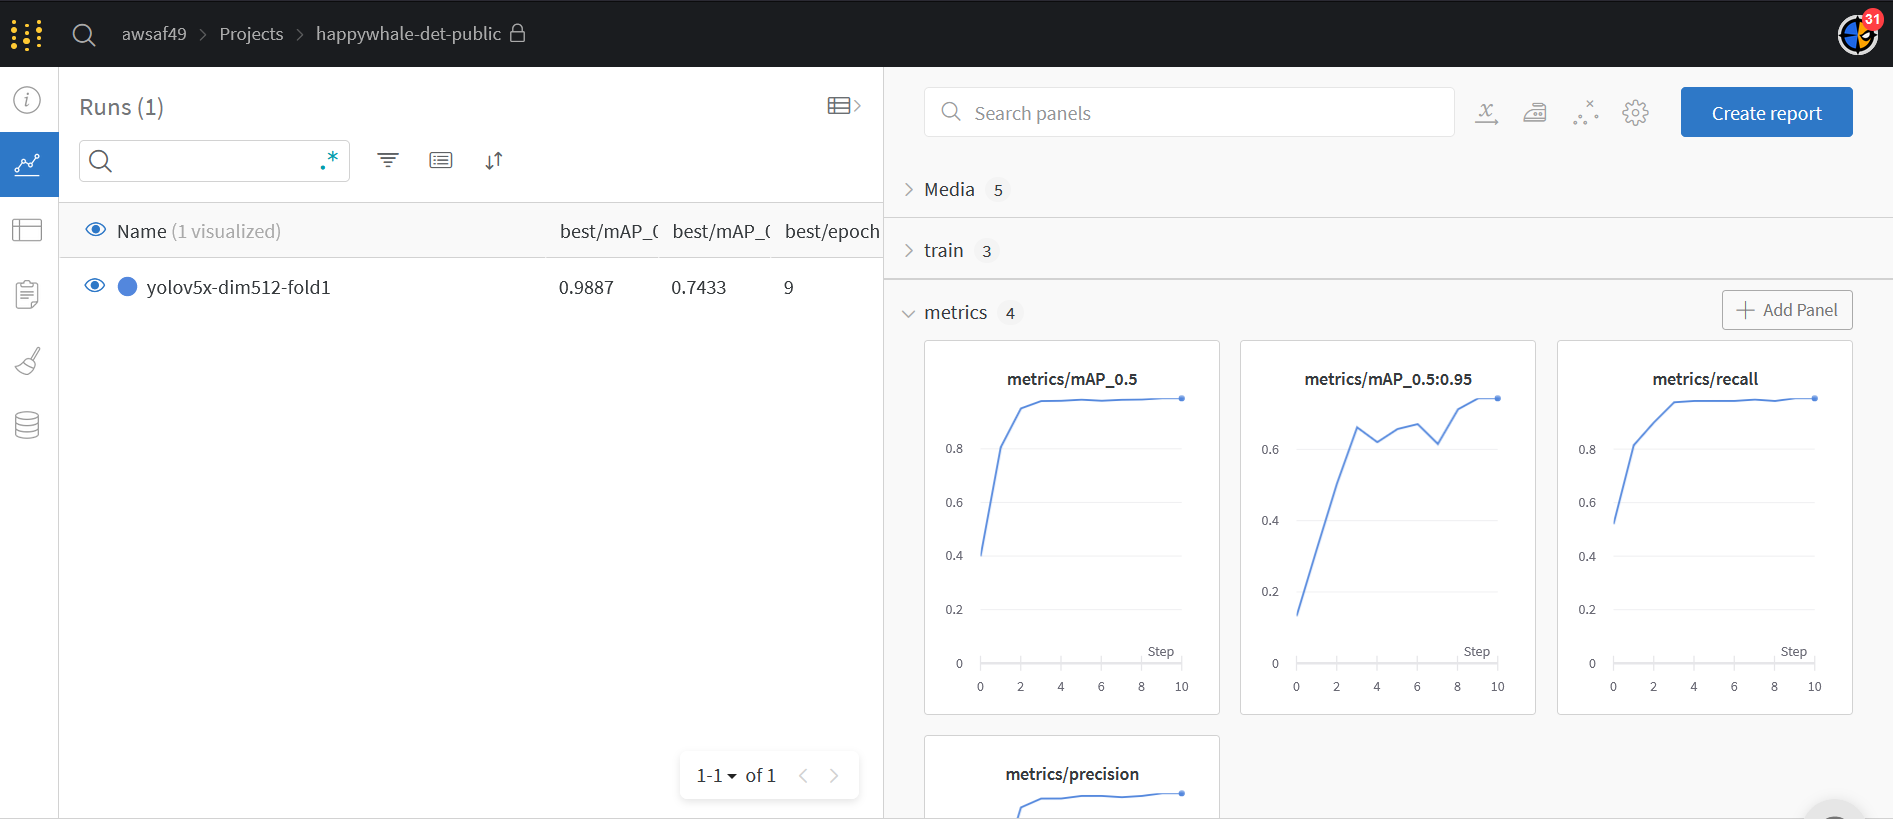

## Output Files

In [ ]:
OUTPUT_DIR = '{}/{}'.format(PROJECT, NAME)
!ls {OUTPUT_DIR}

In [ ]:
!ls {OUTPUT_DIR}/weights/best.pt

# 🔭 Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch2.jpg'))

## Score Vs Epoch

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/results.png'));

## Confusion Matrix

In [ ]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/confusion_matrix.png'));

## Metrics

In [ ]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'{OUTPUT_DIR}/{metric}_curve.png'));
    plt.show()

# **Whale and Dolphin** Data 🐋🐬

In [ ]:
class CFG:
    seed = 42
    base_path = '/kaggle/input/happy-whale-and-dolphin'

In [ ]:
train_output = '/kaggle/working/output/train'
test_output = '/kaggle/working/output/test'

In [ ]:
df2 = pd.read_csv(f"/kaggle/input/happywhale-data-distribution/train.csv")
df2["image_id"] = df2["image"]
df2["label_path"] = train_output + "/labels/" + df2["image_id"].str.replace('jpg','txt')


test_df2 = pd.read_csv(f"/kaggle/input/happywhale-data-distribution/test.csv")
test_df2["image_id"] = test_df2["image"]
test_df2["label_path"] = test_output + "/labels/" + test_df2["image_id"].str.replace('jpg','txt')

print("Train Images: {:,} | Test Images: {:,}".format(len(df2), len(test_df2)))


## Predict on **Train**

In [ ]:
!rm -rf {train_output}
!mkdir -p {train_output}

In [ ]:
!python detect.py --img {DIM}\
--source /kaggle/input/happy-whale-and-dolphin/train_images\
--weights {OUTPUT_DIR}/weights/best.pt\
--project /kaggle/working/output --name train\
--conf 0.01 --iou 0.4 --max-det 1\
--save-txt --save-conf\
--nosave\
--half\
--exist-ok

## Visualize **Train**

In [ ]:
label_paths = glob.glob(f"{train_output}/labels/*")
np.random.shuffle(label_paths)

y = 2
x = 5
plt.figure(figsize=(4 * x, 4 * y))
for idx in range(x * y):
    label_path = label_paths[idx]
    image_id = label_path.split("/")[-1].replace("txt", "jpg")
    row = df2[df2.image_id == image_id].squeeze()
    image_path = f"/kaggle/input/happy-whale-and-dolphin/train_images/{image_id}"
    img = load_image(image_path)
    img = cv2.resize(img, (512, 512))
    image_height = row.height
    image_width = row.width
    with open(label_path) as f:
        data = f.read().strip().split(' ')
    annot = np.array(data).reshape(-1, 6).astype(float)
    bboxes_yolo = annot[..., 1:]
    labels = annot[..., 0].astype(int).tolist()
    names = ["whale/dolphin"] * len(bboxes_yolo)
    plt.subplot(y, x, idx + 1)
    plt.imshow(
        draw_bboxes(
            img=img,
            bboxes=bboxes_yolo,
            classes=names,
            class_ids=labels,
            class_name=True,
            colors=colors,
            bbox_format="yolo",
            line_thickness=2,
        )
    )
    plt.axis("OFF")
plt.tight_layout()
plt.show()


## Predict on **Test**

In [ ]:
!rm -rf {test_output}
!mkdir -p {test_output}

In [ ]:
!python detect.py --img {DIM}\
--source /kaggle/input/happy-whale-and-dolphin/test_images\
--weights {OUTPUT_DIR}/weights/best.pt\
--project /kaggle/working/output --name test\
--conf 0.001 --iou 0.4 --max-det 1\
--save-txt --save-conf\
--nosave\
--half\
--exist-ok

## Visualize **Test**

In [ ]:
label_paths = glob.glob(f"{test_output}/labels/*")
np.random.shuffle(label_paths)

y = 2
x = 5
plt.figure(figsize=(4 * x, 4 * y))
for idx in range(x * y):
    label_path = label_paths[idx]
    image_id = label_path.split("/")[-1].replace("txt", "jpg")
    row = test_df2[test_df2.image_id == image_id].squeeze()
    image_path = f"/kaggle/input/happy-whale-and-dolphin/test_images/{image_id}"
    img = load_image(image_path)
    img = cv2.resize(img, (512, 512))
    image_height = row.height
    image_width = row.width
    with open(label_path) as f:
        data = f.read().strip().split(' ')
    annot = np.array(data).reshape(-1, 6).astype(float)
    bboxes_yolo = annot[..., 1:]
    labels = annot[..., 0].astype(int).tolist()
    names = ["whale/dolphin"] * len(bboxes_yolo)
    plt.subplot(y, x, idx + 1)
    plt.imshow(
        draw_bboxes(
            img=img,
            bboxes=bboxes_yolo,
            classes=names,
            class_ids=labels,
            class_name=True,
            colors=colors,
            bbox_format="yolo",
            line_thickness=2,
        )
    )
    plt.axis("OFF")
plt.tight_layout()
plt.show()

## Process **Annotations**

In [ ]:
def get_annot(row, with_conf=True):
    try:
        with open(row['label_path'], 'r') as f:
            data = f.read().strip().split(' ')
    except:
        return row # don't have any label
    data = np.array(data).reshape(-1, 6 if with_conf else 5).astype(float)
    if with_conf:
        bbox = data[:, 1:-1]
        conf = data[:, -1]
        row['conf'] = conf
    else:
        bbox = data[:, 1:]
    bbox = yolo2voc(bbox, row['height'], row['width'])
    bbox = bbox.round().astype(np.int32)
    row['bbox'] = bbox
    return row

In [ ]:
df2 = df2.progress_apply(get_annot, axis=1)
df2.to_csv('/kaggle/working/train.csv',index=False)
display(df2.head())

test_df2 = test_df2.progress_apply(get_annot, axis=1)
test_df2.to_csv('/kaggle/working/test.csv',index=False)
display(test_df2.head())

# ✂️ Remove Files

In [ ]:
!rm -r {IMAGE_DIR}
!rm -r {LABEL_DIR}

# 💡 Reference
* [Humpback Whale Identification - Fluke Location](https://www.kaggle.com/martinpiotte/humpback-whale-identification-fluke-location)

<div align="center"><img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png" width=400>